## PART 1 : Loading and exploring the .hea file (file containing record information)

## STEP 1 : Run only the following cell

In [1]:
"""
Import all required libraries
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heartpy as hp
import scipy.io
import wfdb
"""
https://github.com/MIT-LCP/wfdb-python
"""

'\nhttps://github.com/MIT-LCP/wfdb-python\n'

## STEP 3: Run the following 2 cells to load desired files

## Run cells to load files

Enter the path of .hea file for visualization: /Users/GEETIKA/Downloads/training2017/training2017/A00001.hea
File loaded, processing file. Please wait!


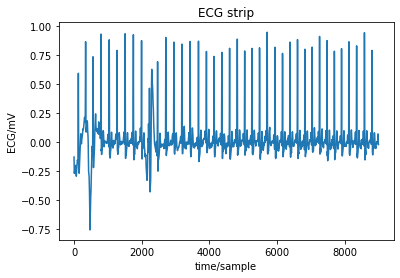

{'record_name': 'A00001',
 'n_sig': 1,
 'fs': 300,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 9000,
 'base_time': datetime.time(5, 5, 15),
 'base_date': datetime.date(2000, 5, 1),
 'comments': [],
 'sig_name': ['ECG'],
 'p_signal': array([[-0.127],
        [-0.162],
        [-0.197],
        ...,
        [-0.018],
        [-0.022],
        [-0.021]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['A00001.mat'],
 'fmt': ['16'],
 'samps_per_frame': [1],
 'skew': [None],
 'byte_offset': [24],
 'adc_gain': [1000.0],
 'baseline': [0],
 'units': ['mV'],
 'adc_res': [16],
 'adc_zero': [0],
 'init_value': [-127],
 'checksum': [0],
 'block_size': [0],
 'base_datetime': datetime.datetime(2000, 5, 1, 5, 5, 15)}

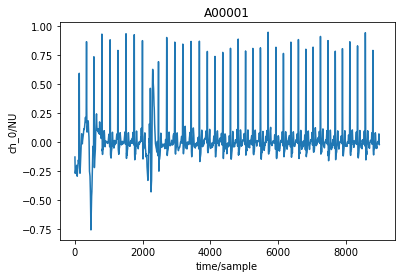

(array([[-0.127],
        [-0.162],
        [-0.197],
        ...,
        [-0.018],
        [-0.022],
        [-0.021]]),
 {'fs': 300,
  'sig_len': 9000,
  'n_sig': 1,
  'base_date': datetime.date(2000, 5, 1),
  'base_time': datetime.time(5, 5, 15),
  'units': ['mV'],
  'sig_name': ['ECG'],
  'comments': []})

In [20]:
"""
Run to upload header file and see visualization 
"""
import sys
import os

user_input = input("Enter the path of .hea file for visualization: ")
assert os.path.exists(user_input), "File not found at, "+str(user_input)

user_input = user_input[:-4]
record = wfdb.rdrecord(user_input)
print("File loaded, processing file. Please wait!")
func_plotecg(record)
obtain_signals(user_input)

Enter the path of .mat file: /Users/GEETIKA/Downloads/training2017/training2017/A00001.mat
File loaded, processing file. Please wait!


C:\Users\GEETIKA\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\GEETIKA\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\GEETIKA\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\GEETIKA\A

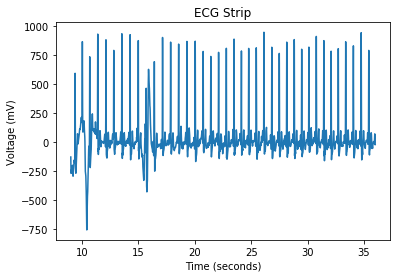

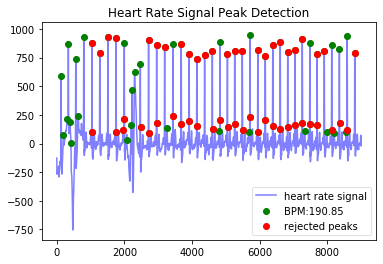

Patient's heart rate is 190.84821428571428 beats per minute and he/she breathes every 1.9883333333333333 seconds


C:\Users\GEETIKA\Anaconda3\lib\site-packages\heartpy\preprocessing.py:56: RuntimeWarning: overflow encountered in short_scalars
  rng = np.max(data) - np.min(data)


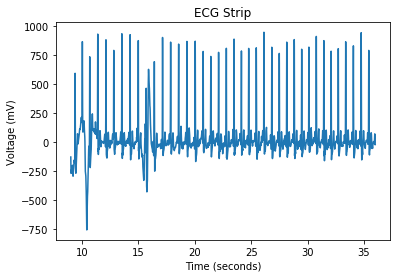

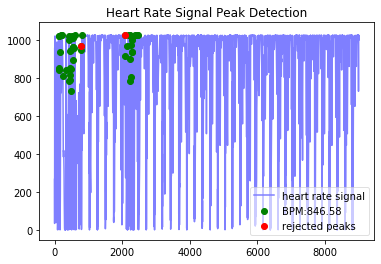

Patient's heart rate is 846.5845464725644 beats per minute and he/she breathes every 0.741 seconds when peak enhancing function was used.


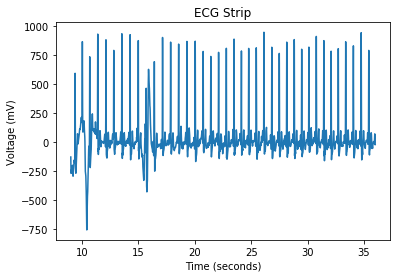

Patient's heart rate is 504.297 beats per minute when peak detection was done using scipy


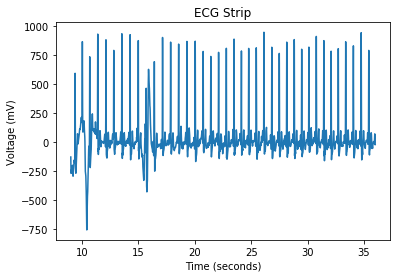

Patient's heart rate is 560.062 beats per minute when peak detection was done using scipy and used ecg strip calculation


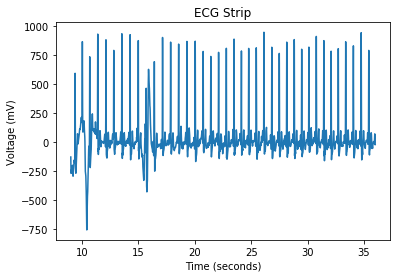

Patient's heart rate is 614.644 beats per minute done using scipy peak detection and filtering


In [21]:
import sys
import os

user_input = input("Enter the path of .mat file: ")
assert os.path.exists(user_input), "File not found at, "+str(user_input)
mat = scipy.io.loadmat(user_input)
print("File loaded, processing file. Please wait!")
df = create_df(mat)
df = add_time_df(df)
wd, measures, string = hb_rate(df)
print(string)
wd_en, measures_en, string_en = hb_rate_enhance(df)
print(string_en)
string_sc = hb_rate_scipy(df)
print(string_sc)
string_sc2 = hb_rate_scipy2(df)
print(string_sc2)
string_filtering = hb_rate_filtering(df)
print(string_filtering)

## STEP 2 : Run all below this cell

## 1. Processing .hea file

In [2]:
"""
Plot ecg signal and print the details of the record using saved record
"""
def func_plotecg(record):
    wfdb.plot_wfdb(record=record, title='ECG strip')
    display(record.__dict__)

In [3]:
"""
ECG signal can also be plotted using rdsamp function by saving signal directly
"""
def obtain_signals(file):
    signals, fields = wfdb.rdsamp(file)
    wfdb.plot_items(signal=signals, fs=fields['fs'], title='A00001')
    display((signals, fields))

## 2. Pre-processing functions

In [4]:
"""
Save dictionary values to python dataframe for easier processing
Transpose the Dataframe to store each observation as a separate row
Reset index
"""
def create_df(mat):
    df = pd.DataFrame.from_dict(mat['val'])
    df = pd.DataFrame.transpose(df)
    df = df.reset_index()
    return df

In [5]:
"""
Create a new 'Time' column in the dataframe and calculate time using sampling frequency
The Data Description available here https://physionet.org/content/challenge-2017/1.0.0/ states that patient 
'A00001' has a normal ECG plot (Figure 1) and the minimum time recorded is 9 seconds (Table 2), hence the first 
observation starts at 9 seconds and the time difference between two observation is calculated using the sampling 
frequency.
"""
def add_time_df(df):
    df = df.rename(columns = {'index': 'Samples', 0: 'Voltage'})
    df['Time_sec'] = 'NaN'
    df['Time_sec'][0] = 9
    for i in range(1, len(df)):
        df['Time_sec'][i] = df['Time_sec'][i-1] + (1/300)
        df['Time_sec'][i] = float(df['Time_sec'][i])
        df['Time_sec'][i] = round(df['Time_sec'][i],3)
    return df

## 3. Calculating heart rate and breathing rate using heartpy package

### 3.1 Using no filters and no peak enhancing methods

### Processing functions

In [6]:
"""
Reference : https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/_modules/heartpy/analysis.html

Formulae used by the heart_py function to calculate important measures:

rr_list = (np.diff(peaklist) / sample_rate) * 1000.0 
Dividing by sample rate helps us obtain the approximate time between each observation recorded which is then converted to ms
(as voltage is in mv), this is finally multiplied by the difference between two adjacent peaks (R peak)
measures['bpm'] =
60000 / np.mean(rr_list)


This is the main function and will call other processing functions to obtain desired results.

Args: df (Pandas DataFrame) - Input dataframe (created by using .mat file) name to the function

Output: working_data (dict) - It includes values of peaks, RR intervals, etc, detected by the process function
        measures (dict) - Dictionary object used by heartpy to store computed measures.
"""
def hb_rate(df):
    df = data_process(df)
    plot_ecg(df)
    working_data, measures = hp.process(df['Voltage'], sample_rate = 300)
    breathing_rate = breathing_rate_conversion(measures['breathingrate'])
    plotter(working_data, measures)
    return working_data, measures, "Patient's heart rate is {} beats per minute and he/she breathes every {} seconds" .format(measures['bpm'], breathing_rate)

In [7]:
"""
This function removes any non-numeric observations or any observations with missing values in the data. It is possible to 
generate a warning message for the user if the recorded observation (voltage) is beyond a certain limit (eg: 300 mV)

Args: df (Pandas DataFrame) - Input dataframe (created by using .mat file) name to the function

Output: df (Pandas DataFrame) - Modified dataframe (after removing any bad data)
"""

def data_process(df):
    
    if df.isnull().values.any():
        print("Removing observations with missing values")
        df = df.dropna(how='any')
    str_index = list()
    for i in range(len(df)):
        if (
            (df['Samples'].dtype == object
                and isinstance(df.iloc[i]['Samples'], str))
            or
            (df['Voltage'].dtype == object
                and isinstance(df.iloc[i]['Voltage'], str))):
            try:
                df.iloc[i] = df.iloc[i].astype(float)
            except ValueError:
                print("Time or voltage is non-numeric, removing non-numeric observations")
                str_index.append(i)
    df = df.drop(df.index[str_index], axis=0)
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    return pd.DataFrame(df)

In [8]:
"""
This function plots time vs voltage, which basically gives a ECG strip. Same as we obtained from .hea file

Args: df (Pandas DataFrame) - Modified dataframe (after removing any bad data)

Output: Plot
"""

def plot_ecg(df):
    plt.plot(df['Time_sec'],df['Voltage'])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (mV)')
    plt.title('ECG Strip')
    plt.show()

In [9]:
"""
This function converts frequency to time for breathing rate

Args: br(float) - Obtained from heartpy.process function 'measures' dictionary

Output: Breathing rate in seconds
"""

def breathing_rate_conversion(br):
    br_sec = 1 / br
    return br_sec

In [10]:
"""
Visualization code : to see which peaks are being detected by the function
"""
def plotter(wd, measures):
    hp.plotter(wd, measures, show=True, title='Heart Rate Signal Peak Detection', moving_average=False)

### 3.2 Using peak enhancing methods

Please note that this function using pre-processing functions from the previous step (3.1)

In [11]:
"""
Reference : https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/_modules/heartpy/analysis.html

Formulae used by the heart_py function to calculate important measures:

rr_list = (np.diff(peaklist) / sample_rate) * 1000.0 
Dividing by sample rate helps us obtain the approximate time between each observation recorded which is then converted to ms
(as voltage is in mv), this is finally multiplied by the difference between two adjacent peaks (R peak)
measures['bpm'] = 60000 / np.mean(rr_list)


This is the main function and will call other processing functions to obtain desired results.

Args: df (Pandas DataFrame) - Input dataframe (created by using .mat file) name to the function

Output: working_data (dict) - It includes values of peaks, RR intervals, etc, detected by the process function
        measures (dict) - Dictionary object used by heartpy to store computed measures.
"""
def hb_rate_enhance(df):
    df = data_process(df)
    df['En_peaks'] = np.nan
    df['En_peaks'] = hp.enhance_peaks(df['Voltage'], iterations=2)
    plot_ecg(df)
    working_data, measures = hp.process(df['En_peaks'], sample_rate = 300)
    plotter(working_data, measures)
    breathing_rate = breathing_rate_conversion(measures['breathingrate'])
    return working_data, measures, "Patient's heart rate is {} beats per minute and he/she breathes every {} seconds when peak enhancing function was used." .format(measures['bpm'], breathing_rate)

## 4. Calculating heart rate using scipy package

The peak detection is done using the scipy package, I applied bandpass filter to get rid of noise (Part 4.2). This is not necessary as 
it is mentioned here https://physionet.org/content/challenge-2017/1.0.0/ that the signal is already filtered using band pass filtered by AliveCor 
device (who donated the data).

### 4.1 Without filtering

### 4.1.1 Calculate heart rate using time in milliseconds : by getting a mean of RR intervals 

In [12]:
"""
This function acts as the main function and will call other functions for processing

Args: df(Pandas DataFame) - Input dataframe (created by using .mat file) name to the function

Output: Returns a string containg patient heart rate
"""
def hb_rate_scipy(df):
    df = data_process(df)
    plot_ecg(df)
    peaks, rr_list, no_beats = detect_peak(300, df['Voltage'])
    bpm = calculate_bpm(rr_list)
    return "Patient's heart rate is {} beats per minute when peak detection was done using scipy" .format(bpm)

In [13]:
"""
This function detects peaks using scipy's find_peaks function

Args: fs(integer) - Sampling frequency, i.e. 300 Hz
      voltage - Column of a pandas DataFrame
      
Output: peaks(list) - The indices of the peaks (peaks detected by the find_peaks function)
        rr_list(list) - List containing RR intervals calculated using rr_list = (np.diff(peaklist) / sample_rate) * 1000.0 
        no_beats(integer) - Number of peaks
"""
def detect_peak(fs, voltage):
    heights = (max(voltage) - np.mean(voltage)) / 3
    peaks, properties = scipy.signal.find_peaks(voltage)
    no_beats = len(peaks)
    rr_list = (np.diff(peaks) / fs) * 1000
    return peaks, rr_list, no_beats

In [14]:
"""
This function calculates heart rate 
"""
def calculate_bpm(rr_list):
    HR_bpm = 60000 / np.mean(rr_list)
    HR_bpm = round(HR_bpm, 3)
    return HR_bpm

### 4.1.2 Calculate heart rate using ecg strip calculation

In [15]:
"""
This function acts as the main function and will call other functions for processing

Args: df(Pandas DataFame) - Input dataframe (created by using .mat file) name to the function

Output: Returns a string containg patient heart rate
"""
def hb_rate_scipy2(df):
    df = data_process(df)
    plot_ecg(df)
    peaks, rr_list, no_beats = detect_peak(300, df['Voltage'])
    duration_df = duration(df)
    bpm = mean_hr_bpm(duration_df,no_beats)
    return "Patient's heart rate is {} beats per minute when peak detection was done using scipy and used ecg strip calculation" .format(bpm)

In [16]:
"""
Calculate the duration of the signal

Args: df(Pandas DataFrame) - The dataframe obtained after removing any missing values

Output: duration(integer) - Duration of the entire signal in seconds
"""
def duration(df):
    k = len(df)
    duration = df.iloc[k-1][2] - df.iloc[0][2]
    duration = round(duration, 3)
    return duration  # in seconds

In [17]:
"""
This function takes duration of the entire ecg signal and the number of beats detected in the signal to output the heart rate.
The calculation is done using the concept that if the total number of beats in the signal is x, then the number of beats in 
60 seconds will be (x * 60/ total duration)

Args: duration_value(integer) - Duration of the entire signal in seconds
      num_beats(integer) - Total number of beats (or peaks) detected by the signal
"""
def mean_hr_bpm(duration_value, num_beats):
    HR = (num_beats * 60) / (duration_value)
    HR_bpm = round(HR, 3)
    return HR_bpm

### 4.1 With filtering

In [18]:
"""
This function acts as the main function and will call other functions for processing

Args: df(Pandas DataFame) - Input dataframe (created by using .mat file) name to the function

Output: Returns a string containg patient heart rate
"""

def hb_rate_filtering(df):
    df = data_process(df)
    plot_ecg(df)
    filtered_voltage = filtering(df, 300)
    peaks, rr_list, no_beats = detect_peak(300, filtered_voltage)
    bpm = calculate_bpm(rr_list)
    return "Patient's heart rate is {} beats per minute done using scipy peak detection and filtering" .format(bpm)

In [19]:
"""
The function applies band pass filter (butterworth filter) using scipy package's inbuilt functions

Args: df (DataFrame) - Dataframe cleaned after removing bad data
      fs (Integer) - Sampling frequency

Output: filtered_voltage (list)
"""

def filtering(df, fs):
    num_sample = len(df['Voltage'])
    filter_bd = scipy.signal.butter(4, [1/fs, 100/fs], analog=False,
                           btype="band", output="sos")
    filtered_voltage = scipy.signal.sosfilt(filter_bd, df['Voltage'])

    return filtered_voltage

I used heartpy package and scipy package for the analysis. Heartpy package provides a full-proof data analysis tool for ecg signals, whereas the scipy package can be used to find peaks from the ecg signal and then heart rate has to be calculated manually. 

The heart rate was calculated by detecting R peaks from the ecg signal. These peaks were counted which are defined as beats (heart rate). Breathing rate is calculated using the waves within a certain frequency. 

We observe the heart rate to be much higher when the scipy package was used to find peaks because the number of peaks detected were different. 